<a href="https://colab.research.google.com/github/Pickles91/DCAC/blob/main/Prostate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. GPU acceleration is available?



In [1]:
import torch

# Check whether GPU-accelerated computing is available
if torch.cuda.is_available():
    print("------------------------------")
    print("GPU acceleration is available.")
    print("------------------------------")
else:
    print("------------------------------------------------------------------------------------")
    print("Error: GPU acceleration is not available. Please enable GPU in the Runtime settings.")
    print("------------------------------------------------------------------------------------")

------------------------------
GPU acceleration is available.
------------------------------


# 2. Installing nnU-Net

In [2]:
# install nnunet
!pip install nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.1/184.1 kB 971.9 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 12.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.

**Note**: you do not have to restart the Runtime even when the following error appears, this is simply due to a reinstallation of a package - so no worries.


```
WARNING: The following packages were previously imported in this runtime:

[argparse]

You must restart the runtime in order to use newly installed versions.
```

In [1]:
# check if nnunet can be imported
import nnunetv2

# 3. Import Packages for Google Colab

In [2]:
# Import basic packages
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch

# 4. Connect Google Colab with GoogleDrive

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 5. Creating directories for nnUNet data and models


In [11]:
# Creating directories for nnUNet data and models
!mkdir -p "/content/drive/My Drive/Colab Notebooks/nnUNet_raw"
!mkdir -p "/content/drive/My Drive/Colab Notebooks/nnUNet_preprocessed"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/nnUNet_trained_models"
!mkdir -p "/content/drive/My Drive/Colab Notebooks/nnUNet_results"


# Changing directory to nnUNet_raw_data to download and extract data
%cd "/content/drive/MyDrive/Colab Notebooks/nnUNet_raw"

# Downloading and extracting the data for Task05_Prostate
!gdown https://drive.google.com/uc?id=1Ff7c21UksxyT4JfETjaarmuKEjdqe1-a
!tar -xvf Task05_Prostate.tar
!rm Task05_Prostate.tar

# Changing directory back to the parent directory
%cd ..

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw
Downloading...
From (original): https://drive.google.com/uc?id=1Ff7c21UksxyT4JfETjaarmuKEjdqe1-a
From (redirected): https://drive.google.com/uc?id=1Ff7c21UksxyT4JfETjaarmuKEjdqe1-a&confirm=t&uuid=9780ac8f-1756-417d-92ea-c063d38816c2
To: /content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Task05_Prostate.tar
100% 240M/240M [00:01<00:00, 209MB/s]
Task05_Prostate/._dataset.json
Task05_Prostate/dataset.json
Task05_Prostate/._imagesTr
Task05_Prostate/imagesTr/
Task05_Prostate/imagesTr/prostate_16.nii.gz
Task05_Prostate/imagesTr/._prostate_04.nii.gz
Task05_Prostate/imagesTr/prostate_04.nii.gz
Task05_Prostate/imagesTr/prostate_32.nii.gz
Task05_Prostate/imagesTr/prostate_20.nii.gz
Task05_Prostate/imagesTr/prostate_43.nii.gz
Task05_Prostate/imagesTr/prostate_18.nii.gz
Task05_Prostate/imagesTr/prostate_06.nii.gz
Task05_Prostate/imagesTr/prostate_14.nii.gz
Task05_Prostate/imagesTr/prostate_41.nii.gz
Task05_Prostate/imagesTr/prostate_34.nii.gz
Task05

In [12]:
# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()

print("Current Working Directory {}".format(os.getcwd()))
print(" ")
path_dict = {
    "nnUNet_raw" : os.path.join(mount_dir, "nnUNet_raw"),
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(mount_dir, "nnUNet_results"),
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path

def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input:
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder
    """
    if os.path.exists(folder_path):

        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print(" ")
print("If No Error Occured Continue Forward. =)")

Current Working Directory /content/drive/MyDrive/Colab Notebooks
 
/content/drive/My Drive/Colab Notebooks/nnUNet_raw exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_preprocessed exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_results exists.
 
If No Error Occured Continue Forward. =)


In [13]:
# Install virtualenv package, create a virtual environment named 'myenv',
# activate the virtual environment, and install a package named 'package_name'.
!pip install virtualenv
!virtualenv myenv
!source myenv/bin/activate; pip install package_name

created virtual environment CPython3.10.12.final.0-64 in 11534ms
  creator CPython3Posix(dest=/content/drive/My Drive/Colab Notebooks/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: package_name==0.1, pip==24.0, setuptools==69.5.1, wheel==0.43.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


### Dataset Conversion
The Decathlon datasets are 4D nifti files, for nnU-Net they have to be converted to 3D nifti files.

For more information about dataset conversion see: [nnU-Net Dataset Formatting Instructions](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_format.md)

In [14]:
!nnUNetv2_convert_MSD_dataset -i "/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Task05_Prostate"

## Extracting Rule Based Parameters
This will preprocess the dataset to allow fast training and saves it into the "nnUNet_preprocessed" folder.
Further rule based parameters will be extracted in the planning step.

In [15]:
# Prepare the Execution of nnU-Net for Dataset 5
!nnUNetv2_plan_and_preprocess -d 5

Fingerprint extraction...
Dataset005_Prostate
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 32/32 [00:32<00:00,  1.03s/it]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [ 20. 320. 319.], 3d_lowres: [20, 320, 319]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 32, 'patch_size': (320, 320), 'median_image_size_in_voxels': array([320., 319.]), 'spacing': array([0.625, 0.625]), 'normalization_schemes': ['ZScoreNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'resampling_fn_data': 'resample_data_

### Training nnU-Net
here we will train a 3D nnU-Net on Full Resolution for 2 epochs.

To run a normal training use: ```nnUNetTrainer``` instead of ```nnUNetTrainer_1epoch```

In [16]:
# train the 3d nnUnet on the Full Resolution with Dataset 5 and Cross Validation Split 0
!nnUNetv2_train 5 3d_fullres 0 -tr nnUNetTrainer_1epoch

# Training for 2 iterations will take about 11 minutes


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-04-23 02:35:16.160782: do_dummy_2d_data_aug: True
2024-04-23 02:35:16.166652: Creating new 5-fold cross-validation split...
2024-04-23 02:35:16.175877: Desired fold for training: 0
2024-04-23 02:35:16.179792: This split has 25 training and 7 validation cases.
/usr/lib/python3.10/multiproces

## Inference with Pre-Trained Models on Decathlon Prostate Dataset (WIP)
Here we will use a pretrained model on the Prostate Dataset and visualize the results

### Downloading Pretrained Model
First Download the pretrained models and validate that everything works correctly

In [17]:
# Download the Pretrained Model for the Prostate Dataset (Decathlon Dataset)
os.chdir(path_dict["nnUNet_results"])
!gdown 'https://drive.google.com/uc?export=download&id=1gCdlj-O3hgoMDDw2NM8QxvFIGGVbT9Qy'
!nnUNetv2_install_pretrained_model_from_zip nnUNetv2_3dfullres_Model_Dataset005_Prostate.zip
!rm 'nnUNetv2_3dfullres_Model_Dataset005_Prostate.zip'
os.chdir(base_dir)

# takes roughly 9 minutes

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1gCdlj-O3hgoMDDw2NM8QxvFIGGVbT9Qy
From (redirected): https://drive.google.com/uc?export=download&id=1gCdlj-O3hgoMDDw2NM8QxvFIGGVbT9Qy&confirm=t&uuid=b41d1763-65df-4370-a893-7564ae863e2f
To: /content/drive/My Drive/Colab Notebooks/nnUNet_results/nnUNetv2_3dfullres_Model_Dataset005_Prostate.zip
100% 1.66G/1.66G [00:18<00:00, 88.2MB/s]


In [18]:
# Preprocess Prostate Dataset
!nnUNetv2_convert_MSD_dataset -i "${RAW_DATA_PATH}/Task05_Prostate"

Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_convert_MSD_dataset", line 8, in <module>
    sys.exit(entry_point())
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 128, in entry_point
    convert_msd_dataset(args.i, args.overwrite_id, args.np)
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 62, in convert_msd_dataset
    assert len(existing_datasets) == 0, f"Target dataset id {target_id} is already taken, please consider changing " \
AssertionError: Target dataset id 5 is already taken, please consider changing it using overwrite_target_id. Conflicting dataset: ['Dataset005_Prostate'] (check nnUNet_results, nnUNet_preprocessed and nnUNet_raw!)


### Inference on the Prostate Dataset
Use 3d_fullres nnUnet (-c) trained on the test set of dataset 5 (-d 5) and save the outputs

In [19]:
# use fully trained nnU-Net to make predictions on data
!nnUNetv2_predict -i "${nnUNet_raw}/Dataset005_Prostate/imagesTs/" -o "${nnUNet_results}/Dataset005_Prostate/predTs/" -d 5 -c 3d_fullres


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

/usr/local/lib/python3.10/dist-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
There are 16 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start c

## Visualization of Data and Segmentations
Download files from Google Drive:

Images from: ```${nnUNet_raw}/Dataset005_Prostate/imagesTs/```

Segmentations from: ```${RESULTS_FOLDER}/Dataset005_Prostate/predTs/"```


After downloading these files you can visualize them with any volumetric visualization program.
For this we would advise to use [MITK](https://www.mitk.org/wiki/The_Medical_Imaging_Interaction_Toolkit_(MITK)) which already has some great [tutorials](https://www.mitk.org/wiki/Tutorials).


Note:
- If you have not already downloaded it, here is the [MITK Download Link](https://www.mitk.org/wiki/Downloads)

## Visualization of Predictions
Similar to the dataset visualization we would encourage you to do this with MITIK-Workbench.

Here is a quick visualization with python.

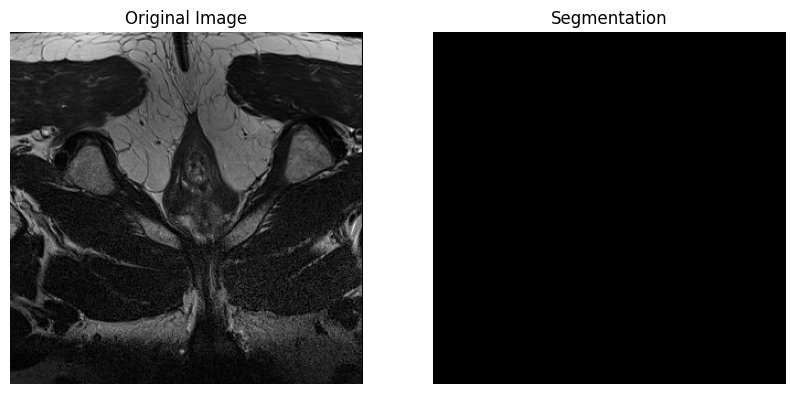

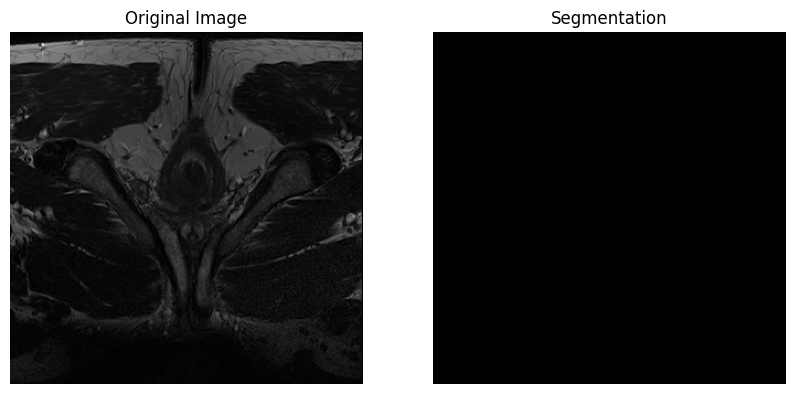

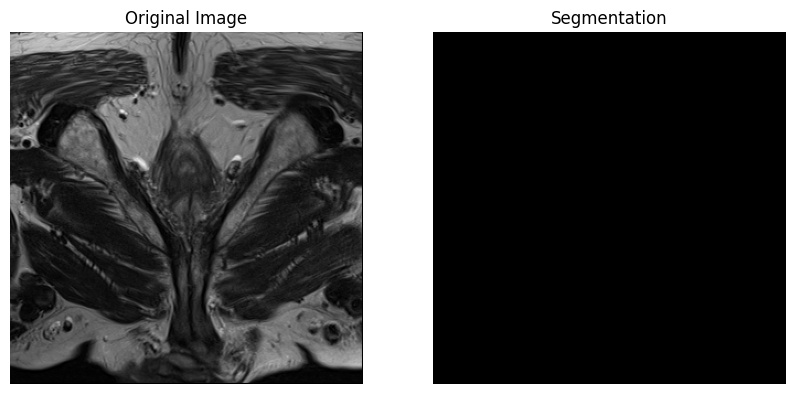

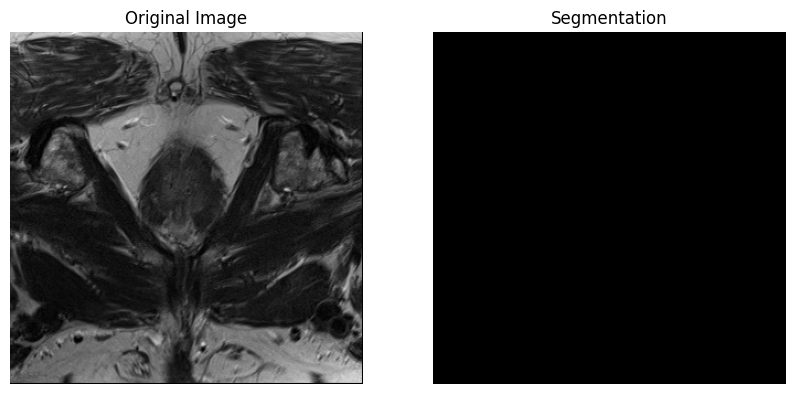

Segmentation file not found for image: prostate_08_0001.nii.gz
Segmentation file not found for image: prostate_03_0001.nii.gz


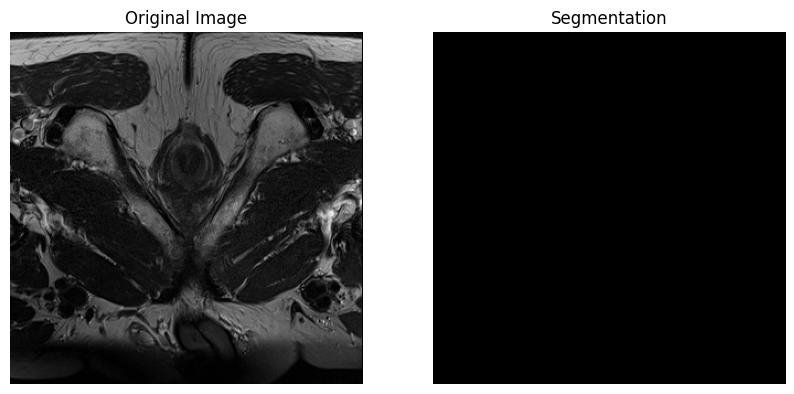

Segmentation file not found for image: prostate_05_0001.nii.gz


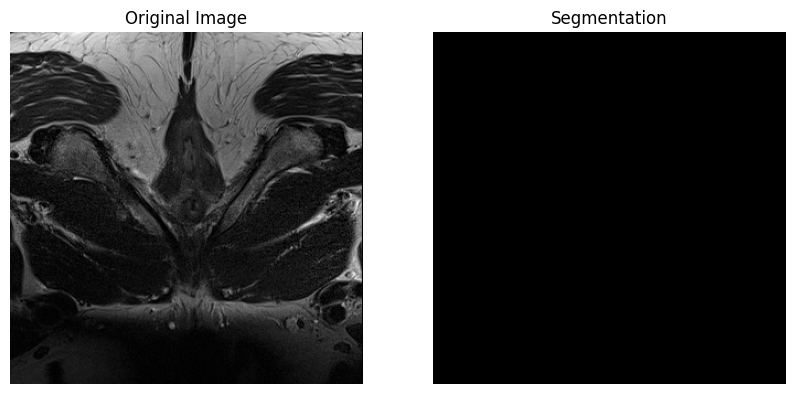

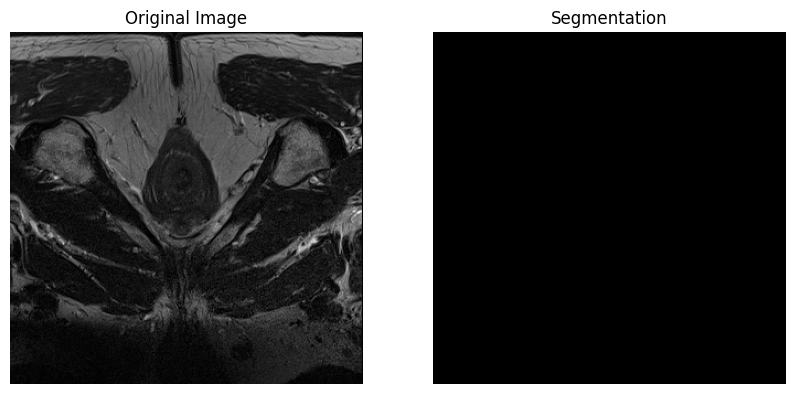

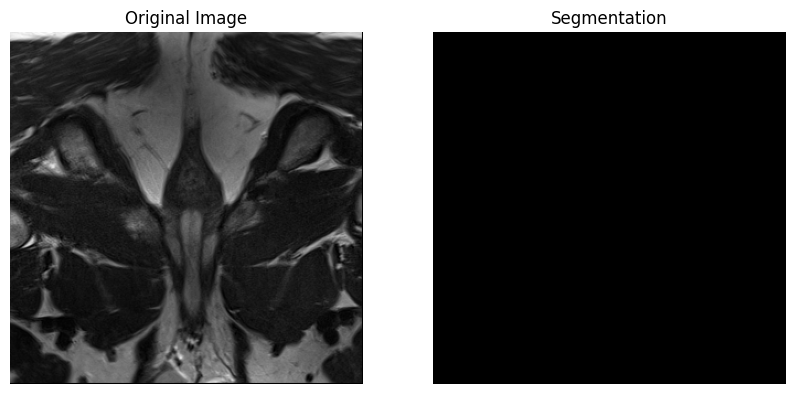

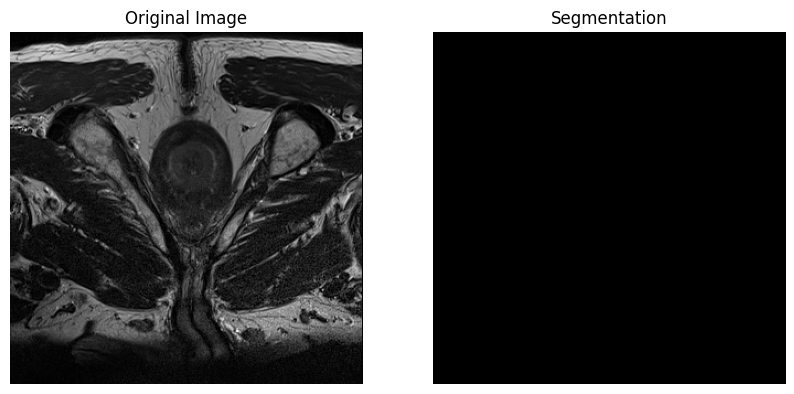

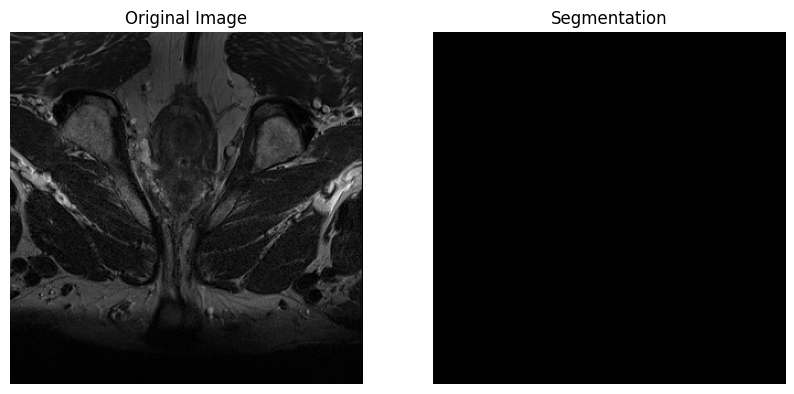

Segmentation file not found for image: prostate_09_0001.nii.gz


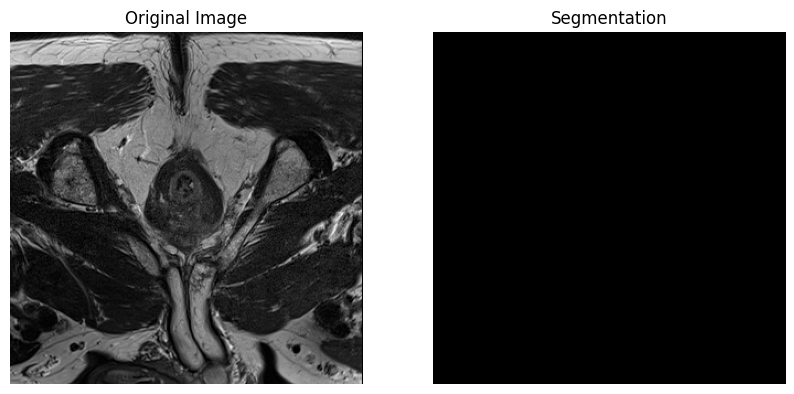

Segmentation file not found for image: prostate_11_0001.nii.gz
Segmentation file not found for image: prostate_12_0001.nii.gz
Segmentation file not found for image: prostate_22_0001.nii.gz
Segmentation file not found for image: prostate_15_0001.nii.gz
Segmentation file not found for image: prostate_19_0001.nii.gz


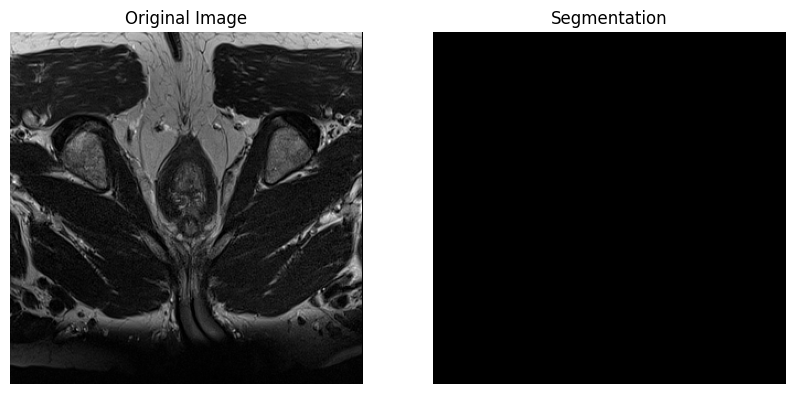

Segmentation file not found for image: prostate_23_0001.nii.gz
Segmentation file not found for image: prostate_26_0001.nii.gz


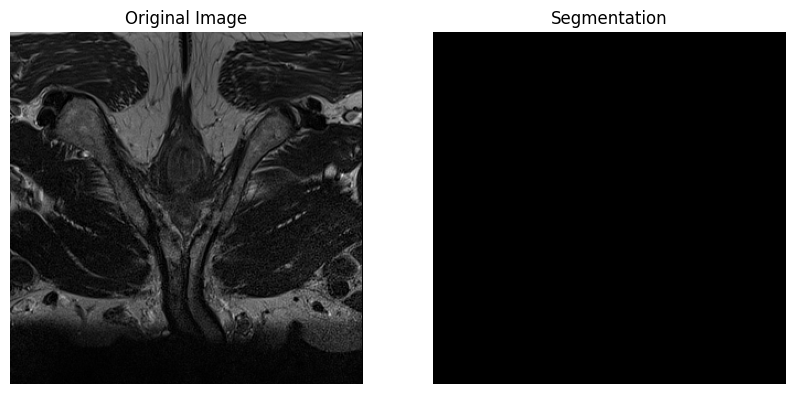

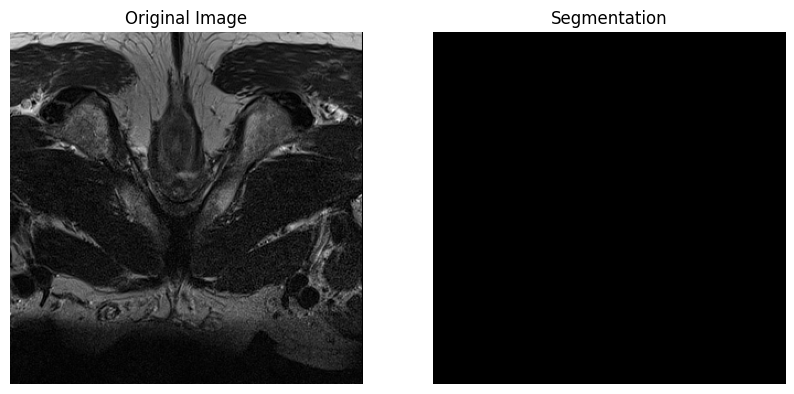

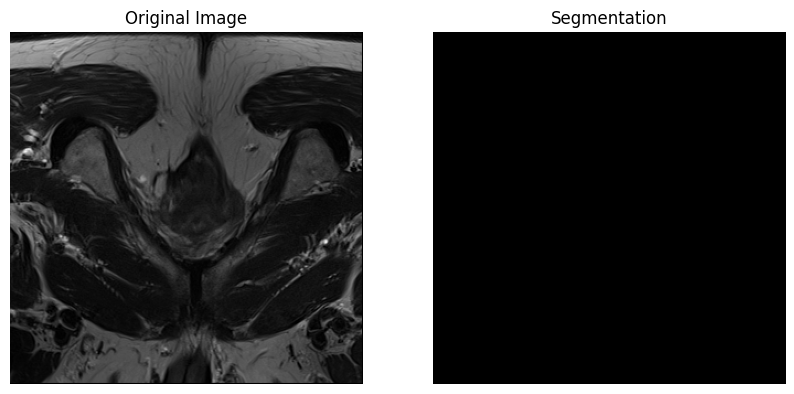

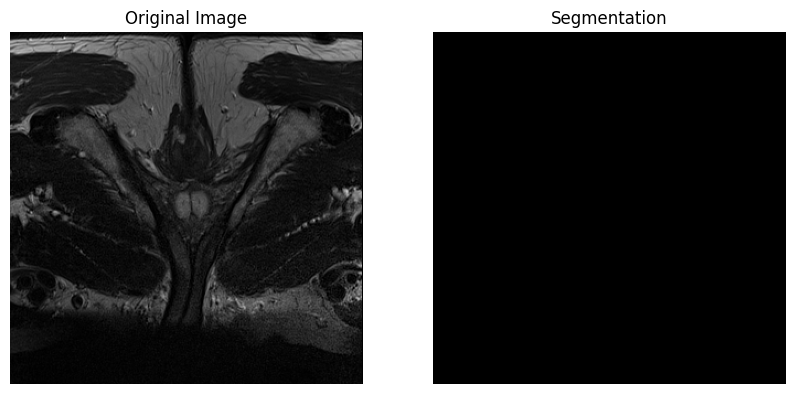

Segmentation file not found for image: prostate_27_0001.nii.gz
Segmentation file not found for image: prostate_45_0001.nii.gz
Segmentation file not found for image: prostate_30_0001.nii.gz
Segmentation file not found for image: prostate_33_0001.nii.gz
Segmentation file not found for image: prostate_36_0001.nii.gz


In [53]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Define paths to image and segmentation data
images_folder = '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_Prostate/imagesTs'
segmentations_folder = '/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset005_Prostate/predTs'

# Load and display images and segmentations
for image_name in os.listdir(images_folder):
    # Load image
    image_path = os.path.join(images_folder, image_name)
    image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(image)
    # Assuming the image is 3D, select a slice to display
    image_slice = image_array[0]  # Change the index as needed

    # Construct segmentation file name
    segmentation_name = image_name.replace('_0000.nii.gz', '.nii.gz')
    segmentation_path = os.path.join(segmentations_folder, segmentation_name)

    if os.path.exists(segmentation_path):
        segmentation = sitk.ReadImage(segmentation_path)
        segmentation_array = sitk.GetArrayFromImage(segmentation)
        # Assuming the segmentation is 3D, select a slice to display
        segmentation_slice = segmentation_array[0]  # Change the index as needed

        # Display image and segmentation
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_slice, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(segmentation_slice, cmap='gray')  # Assuming segmentation is color-coded
        plt.title('Segmentation')
        plt.axis('off')

        plt.show()
    else:
        print(f"Segmentation file not found for image: {image_name}")
